In [1]:
# Step 1: Install dependencies
!pip install scikit-learn xgboost imbalanced-learn

# Step 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Step 3: Load dataset (PIMA diabetes)
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
df.head()


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 3.4 MB/s eta 0:00:17
    --------------------------------------- 1.3/56.8 MB 4.5 MB/s eta 0:00:13
   - -------------------------------------- 2.1/56.8 MB 4.3 MB/s eta 0:00:13
   -- ------------------------------------- 3.1/56.8 MB 4.3 MB/s eta 0:00:13
   -- ------------------------------------- 4.2/56.8 MB 4.4 MB/s eta 0:00:12
   --- ------------------------------------ 5.2/56.8 MB 4.7 MB/s eta 0:00:12
   ---- ----------------------------------- 6.3/56.8 MB 4.7 MB/s eta 0:00:11
   ----- ---------------------------------- 7.3/56.8 MB 4.7 MB/s eta 0:00:11
   ----- ---------------------------------- 8.4/56.8 MB 4.8 MB/s eta 0:00:11
   ------ --------------------------------- 9.4/56.8 MB 4.8 MB/s eta 0:00:10
   ------- -------------------------------- 10.5/56.8 MB 4.8 MB/s eta 0:00:10
   -------- ------------------------------- 11.5/56.8 MB 4.9 MB/s eta 0:00:10
   -

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Step 4: Data Preprocessing (clean version - no warnings)

# Replace impossible zeros in certain columns with NaN
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Fill missing values with median of each column (safe assignment)
for col in cols_with_zero:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Split features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Balanced dataset shape:", X_res.shape, y_res.shape)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_res, test_size=0.2, random_state=42, stratify=y_res
)



Balanced dataset shape: (1000, 8) (1000,)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Final Accuracy: 0.815

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       100
           1       0.80      0.84      0.82       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



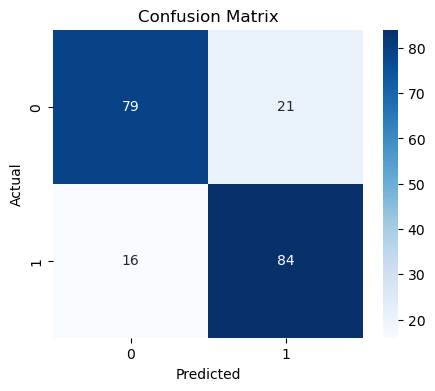

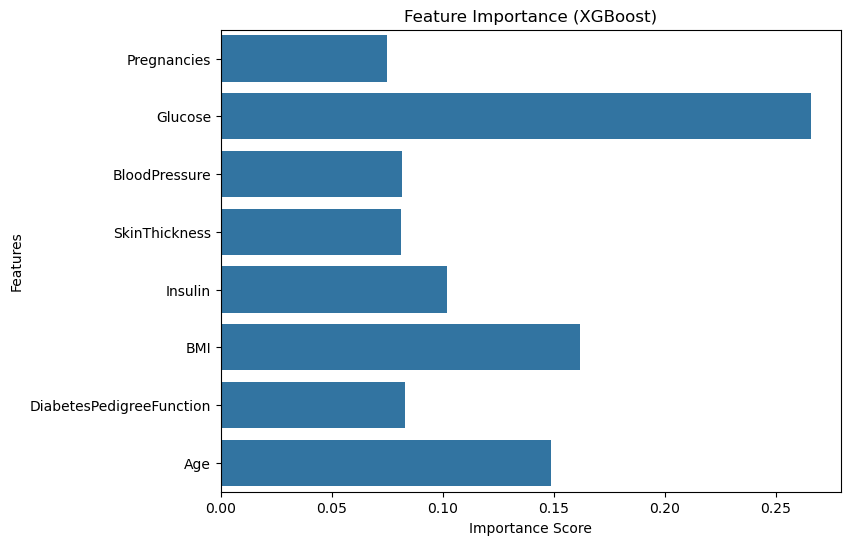

In [9]:
# -----------------------
# Step 8: Build and train model (XGBoost with GridSearchCV)
# -----------------------
from xgboost import XGBClassifier

# Base model (no deprecated params)
model = XGBClassifier(eval_metric='logloss', random_state=42)

# Hyperparameter tuning
params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0]
}

grid = GridSearchCV(model, params, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Best model
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# -----------------------
# Step 9: Evaluate model
# -----------------------
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Final Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -----------------------
# Step 10: Feature Importance
# -----------------------
plt.figure(figsize=(8,6))
importance = best_model.feature_importances_
features = X.columns  # original feature names
sns.barplot(x=importance, y=features)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()




Logistic Regression Results:
Accuracy: 0.735
Precision: 0.7373737373737373
Recall: 0.73
F1 Score: 0.7336683417085427

SVM Results:
Accuracy: 0.805
Precision: 0.7798165137614679
Recall: 0.85
F1 Score: 0.8133971291866029

Random Forest Results:
Accuracy: 0.81
Precision: 0.7980769230769231
Recall: 0.83
F1 Score: 0.8137254901960784


C:\Users\oneek\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

ANN Results:
Accuracy: 0.74
Precision: 0.7352941176470589
Recall: 0.75
F1 Score: 0.7425742574257426

Model Comparison:



,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.735,0.737374,0.73,0.733668
SVM,0.805,0.779817,0.85,0.813397
Random Forest,0.810,0.798077,0.83,0.813725
ANN (Keras),0.740,0.735294,0.75,0.742574


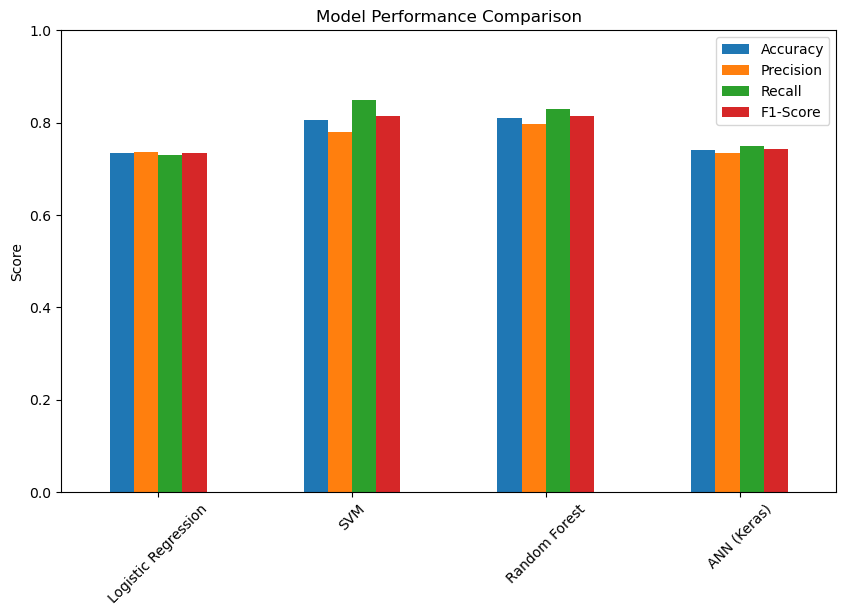

In [11]:
# -----------------------
# Additional Models (besides XGBoost)
# -----------------------
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dictionary to collect results
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = [acc, prec, rec, f1]
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    return model, y_pred

# Logistic Regression
lr_model, lr_pred = evaluate_model("Logistic Regression",
                                   LogisticRegression(max_iter=1000, random_state=42),
                                   X_train, y_train, X_test, y_test)

# SVM
svm_model, svm_pred = evaluate_model("SVM",
                                     SVC(kernel="rbf", probability=True, random_state=42),
                                     X_train, y_train, X_test, y_test)

# Random Forest
rf_model, rf_pred = evaluate_model("Random Forest",
                                   RandomForestClassifier(n_estimators=200, random_state=42),
                                   X_train, y_train, X_test, y_test)

# -----------------------
# ANN (Keras Deep Learning)
# -----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

ann = Sequential([
    Dense(16, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                  verbose=0, callbacks=[early_stop])

# Evaluate ANN
ann_pred = (ann.predict(X_test) > 0.5).astype("int32")
acc = accuracy_score(y_test, ann_pred)
prec = precision_score(y_test, ann_pred)
rec = recall_score(y_test, ann_pred)
f1 = f1_score(y_test, ann_pred)
results["ANN (Keras)"] = [acc, prec, rec, f1]

print("\nANN Results:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

# -----------------------
# Comparison Table
# -----------------------
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T
print("\nModel Comparison:\n")
display(results_df)

# Plot comparison
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()
